# Risk Assessment for Wildfire

- A workflow from the CLIMAAX [Handbook](https://handbook.climaax.eu/) and [FIRE](https://github.com/CLIMAAX/FIRE) GitHub repository.
- See our [how to use risk workflows](https://handbook.climaax.eu/notebooks/workflows_how_to.html) page for information on how to run this notebook.

## Methodology

In the process of determining the hazard classes (either 6 or 12 classes) through our Machine Learning (ML) algorithm, we will employ the overarching risk formula: 

    Risk = Hazard * Vulnerability * Exposure

The hazard component is already defined by the ML algorithm in terms of intensities. Our subsequent steps involve preprocessing the vulnerability and exposure data obtained respectively from the Joint Research Centre (JRC) and OpenStreetMap. We will identify areas where exposed elements intersect and evaluate the hazard levels in those areas using vulnerability curves, also known as damage level curves, to calculate the overall risk. Subsequently, we will aggregate the results at the municipality (or provincial) level to generate a comprehensive Risk Map for the target area.

### Vulnerability Data

:::{dropdown} 1 Population vulnerability

Aggregated index of population vulnerability. Based on the population exposed in the vulnerable Wildland Urban Interface derived after https://doi.org/10.2760/46951.

- **Layer name**: Population vulnerability
- **Layer group**: Vulnerability
- **Layer unit**: Percentile (%)
- **CSV file**: `var-vuln-pop_unit-dimensionless.csv`
- **Projection**: the native geospatial projection is EURO-CORDEX (https:euro-cordex.net).
    European grid of the Coordinated Regional Climate Downscaling Experiment (CORDEX) by the World Climate Research Programme (WCRP), https://purl.org/INRMM-MiD/z-THSLFEYQ.
    The standard grid EUR-11 is used (grid cell resolution of approximately 0.11 degrees, or about 12.5 km).
    Available reprojection information for WGS84 and Lambert Azimuthal Equal-Area projection (ETRS89-LAEA).
:::

:::{dropdown} 2 Ecological vulnerability

Aggregated index of ecological vulnerability.

- **Layer name**: Ecological vulnerability
- **Layer group**: Vulnerability
- **Layer unit**: Percentile (%)
- **CSV file**: `var-vuln-ecol_unit-dimensionless.csv`
- **Projection**: the native geospatial projection is EURO-CORDEX (https:euro-cordex.net).
  European grid of the Coordinated Regional Climate Downscaling Experiment (CORDEX) by the World Climate Research Programme (WCRP), https://purl.org/INRMM-MiD/z-THSLFEYQ.
  The standard grid EUR-11 is used (grid cell resolution of approximately 0.11 degrees, or about 12.5 km).
  Available reprojection information for WGS84 and Lambert Azimuthal Equal-Area projection (ETRS89-LAEA).
:::

:::{dropdown} 3 Economic vulnerability

Aggregated index of economic vulnerability.
Based on vegetation restoration cost，for forest and agriculture areas.

- **Layer name**: Economic vulnerability
- **Layer group**: Vulnerability
- **Layer unit**: Percentile (%)
- **CSV file**: `var-vuln-econ_unit-dimensionless.csv`
- **Projection**: the native geospatial projection is EURO-CORDEX (https:euro-cordex.net).
  European grid of the Coordinated Regional Climate Downscaling Experiment (CORDEX) by the World Climate Research Programme (WCRP), https://purl.org/INRMM-MiD/z-THSLFEYQ.
  The standard grid EUR-11 is used (grid cell resolution of approximately 0.11 degrees, or about 12.5 km).
  Available reprojection information for WGS84 and Lambert Azimuthal Equal-Area projection (ETRS89-LAEA).
:::

:::{dropdown} 4 Ecological-economic vulnerability

Aggregated index of ecological and economic vulnerability.

- **Layer name**: Ecological-economic vulnerability
- **Layer group**: Vulnerability
- **Layer unit**: Percentile (%)
- **CSV file**: `var-vuln-ecol-econ_unit-dimensionless.csv`
- **Projection**: the native geospatial projection is EURO-CORDEX (https:euro-cordex.net).
  European grid of the Coordinated
  Regional Climate Downscaling Experiment (CORDEX) by the World Climate Research Programme (WCRP), https://purl.org/INRMM-MiD/z-THSLFEYQ.
  The standard grid EUR-11 is used (grid cell resolution of approximately 0.11 degrees, or about 12.5 km).
  Available reprojection information for WGS84 and Lambert Azimuthal Equal-Area projection (ETRS89-LAEA).
:::


### Possible Exposure Data: Elements at Risk

1. Roads from OSM like primary, secondary, tertiary
2. Buildings and properties with different categories like hospitals, hotels, schools, shelters
3. Wildland Urban interface (WUI)

## Preparation work

### Load libraries

Importing libraries required for the assessment and pre-processing of the data

:::{admonition} Find more info about the libraries used in this workflow here
:class: hint dropdown

- [pathlib](https://docs.python.org/3/library/pathlib.html): File path manipulation and file system access.
- [rasterio](https://rasterio.readthedocs.io/en/stable/): A library for reading and writing geospatial raster datasets. It provides functionalities to work with raster data formats such as GeoTIFF and perform various raster operations.
- [tqdm](https://github.com/tqdm/tqdm): A fast, extensible progress bar for Python and CLI. It allows for easy visualization of loop progress and estimates remaining time.
- [matplotlib.pyplot](https://matplotlib.org/): Matplotlib's plotting interface, providing functions for creating and customizing plots. %matplotlib inline is an IPython magic command to display Matplotlib plots inline within the Jupyter Notebook or IPython console.
- [numpy](https://numpy.org/): A fundamental package for scientific computing with Python. It provides support for large multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays.
- [gdal](https://gdal.org/): Python bindings for the Geospatial Data Abstraction Library (GDAL), used for reading and writing various raster geospatial data formats.
- [geopandas](https://geopandas.org/): Extends the Pandas library to support geometric operations on GeoDataFrames, allowing for easy manipulation and analysis of geospatial data.
- [pandas](https://pandas.pydata.org/): A powerful data manipulation and analysis library for Python. It provides data structures like DataFrame for tabular data and tools for reading and writing data from various file formats.
- [rioxarray](https://corteva.github.io/rioxarray/stable/): Rasterio xarray extension - to make it easier to use GeoTIFF data with xarray.
- [xarray](https://xarray.pydata.org/): An open-source project and Python package that aims to bring the labeled data power of pandas to the physical sciences, by providing N-dimensional variants of the core pandas data structures.
- [cartopy.crs](https://scitools.org.uk/cartopy/docs/latest/): A cartographic projection library for Python.
- [cartopy.feature](https://scitools.org.uk/cartopy/docs/latest/matplotlib/feature_interface.html): Contains a collection of classes and functions that are used to control the appearance of map features.
- [cartopy](https://scitools.org.uk/cartopy/docs/latest/): A cartographic library providing object-oriented map projection definitions, and arbitrary point, line, and polygon transformations.
- [scipy.ndimage](https://docs.scipy.org/doc/scipy/reference/ndimage.html): A submodule of SciPy for numerical operations on n-dimensional arrays.
:::


In [1]:
import pathlib

import numpy as np
from osgeo import gdal
import geopandas as gpd
import rasterio
import rasterio.plot
import rasterio.mask
from rasterio import features
from scipy.ndimage import binary_dilation

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import colors
from matplotlib.patches import Patch

### Sample data

Sample data for the Catalonia case study is available from the CLIMAAX cloud storage. Download instructions are available in the accompanying [hazard assessment workflow](Hazard_assessment_FIRE_ML.ipynb#sample-data) where the data was already used. To run this notebook with the Catalonia example setup, please make sure the files are available for reuse here.


### Path configuration

In [2]:
data_path = pathlib.Path("./data") # general

# Vulnerability data (input)
vul_path_full = data_path / "vulnerability"
vul_files_full = {
    "population": vul_path_full / "population" / "var-vuln-pop_unit-dimensionless.tiff",
    "economical": vul_path_full / "economical" / "var-vuln-econ_unit-dimensionless.tiff",
    "ecological": vul_path_full / "ecological" / "var-vuln-ecol_unit-dimensionless.tiff",
    "ecological-economical": vul_path_full / "ecol_econ" / "var-vuln-ecol-econ_unit-dimensionless.tiff"
}

Set the area name for use in file paths and plot titles:

In [3]:
areaname = "Catalonia"

data_path_area = pathlib.Path(f"./data_{areaname}") # region-specific

# Files and folders from hazard assessment
hazard_path = data_path_area / "hazard"
dem_path_clip = data_path_area / "dem" / "dem_clip.tif"
bounds_path_area = data_path_area / "boundaries" / f"{areaname}_adm_3035.shp"

# NUTS information (input)
nuts_path = data_path / "administrative_units_NUTS" / "NUTS_RG_01M_2021_3035.shp"

# Exposure data: elements at risk (input)
exp_path = data_path_area / "exposure"
exp_files = {
    "Hospitals": exp_path / "hospitals.shp",
    "Hotels": exp_path / "hotels.shp",
    "Schools": exp_path / "schools.shp",
    "Primary roads": exp_path / "primary_roads.shp",
    "Secondary roads": exp_path / "secondary_roads.shp",
    "Tertiary roads": exp_path / "tertiary_roads.shp",
    "Shelters": exp_path / "shelters.shp"
}

# Output folder for vulnerability raster files
vul_path = data_path_area / "vulnerability"
vul_path.mkdir(parents=True, exist_ok=True)

# Output folder for risk raster files
risk_path = data_path_area / "risk"
risk_path.mkdir(parents=True, exist_ok=True)

# Output folder for map plots
maps_path = data_path_area / "maps"
maps_path.mkdir(parents=True, exist_ok=True)

### Function definitions

These functions are going to be used in the next steps of the analysis.
They concern buffering, rasterizing, saving rasters, and calculating the wildfire risk based on hazard and exposure vulnerability.

In [4]:
def rasterize_numerical_feature(gdf, reference_file, column=None, verbose=True):
    """Rasterize a vector file using a reference raster to get the shape and the transform.

    :param gdf: GeoDataFrame with the vector data
    :param reference_file: Path to the reference raster
    :param column: Name of the column to rasterize. If None, it will rasterize the geometries
    :return: Rasterized version of the vector file
    """
    with rasterio.open(reference_file) as f:
        out = f.read(1, masked=True)
        myshape = out.shape
        mytransform = f.transform
    del out
    if verbose:
        print("Shape of the reference raster:", myshape)
        print("Transform of the reference raster:", mytransform)
    out_array = np.zeros(myshape)#   out.shape)
    # this is where we create a generator of geom, value pairs to use in rasterizing
    if column is not None:
        shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf[column]))
    else:
        shapes = ((geom, 1) for geom in gdf.geometry)
    print("Features.rasterize is launched...")
    burned = features.rasterize(shapes=shapes, fill=np.NaN, out=out_array, transform=mytransform)#, all_touched=True)
    #    out.write_band(1, burned)
    print("Features.rasterize is done...")
    return burned


def save_raster_as(array, output_file, reference_file, **kwargs):
    """Save a raster from a 2D numpy array using another raster as reference to get the spatial extent and projection.

    :param array: 2D numpy array with the data
    :param output_file: Path to the output raster
    :param reference_file: Path to a raster who's geotransform and projection will be used
    :param kwargs: Keyword arguments to be passed to rasterio.open when creating the output raster
    """
    with rasterio.open(reference_file) as f:
        profile = f.profile
        profile.update(**kwargs)
        with rasterio.open(output_file, 'w', **profile) as dst:
            dst.write(array.astype(profile['dtype']), 1)


def buffer(exp_arr, pixel_radius = 2):
    kernel = np.ones((2*pixel_radius + 1, 2*pixel_radius + 1))
    exposed_true = binary_dilation(exp_arr > 0, structure = kernel)
    exposed_buffer = np.where((exposed_true == True ) | (exposed_true == 1), 1, 0)
    return exposed_buffer


def contigency_matrix_on_array(xarr, yarr, xymatrix, nodatax, nodatay):
    '''
    xarr: 2D array, rows entry of contingency matrix
    yarr: 2D array, cols entry of contingency matrix
    xymatrix: 2D array, contingency matrix
    nodatax1: value for no data in xarr : if your array has nodata = np.nan >> nodatax or nodatay has to be 1
    nodatax2: value for no data in yarr : if your array has nodata = np.nan >> nodatax or nodatay has to be 1
    '''
    # if arr have nan, mask it with lowest class
    xarr = np.where(np.isnan(xarr), 1, xarr).astype(int)
    yarr = np.where(np.isnan(yarr), 1, yarr).astype(int)
    mask = (xarr == nodatax) | (yarr == nodatay)
    # put lowest class in place of no data
    yarr[mask] = 1
    xarr[mask] = 1
    # apply contingency matrix
    output = xymatrix[xarr-1,yarr-1]
    # mask out no data
    output[mask] = 0
    return output


def plot_raster_V2(raster, ref, cmap='seismic', title='', figsize=(10, 8), dpi=300, outpath=None,
        array_classes=[], classes_colors=[], classes_names=[], shrink_legend=1, xy=(0.5, 1.1),
        labelsize=10, add_to_ax: tuple = None):
    '''plot a raster object with possibility to add basemap and continuing to build upon the same ax example with discrete palette:

    array_classes = [-1, 0, 0.2, 0.4, 0.6, 0.8, 1],  # all the values including nodata
    classes_colors = ['#0bd1f700','#0bd1f8', '#1ff238', '#ea8d1b', '#dc1721', '#ff00ff'], # a color for each range
    classes_names = [ 'no data', 'Very Low', 'Low', 'Medium', 'High', 'Extreme'], # names
    add_to_ax: pass an ais to overlay other object to the same ax. it is a tuple (fig, ax)
    '''
    if add_to_ax is None:
        fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    else:
        fig = add_to_ax[0]
        ax = add_to_ax[1]

    if len(array_classes) > 0 and len(classes_colors) > 0 and len(classes_names) > 0:
        cmap = colors.ListedColormap(classes_colors)
        norm = colors.BoundaryNorm(array_classes, cmap.N)
        # plot the raster
        f = rasterio.plot.show(np.where(ref == -9999, np.nan, raster), ax=ax,
                cmap=cmap, norm=norm, interpolation='none')
        img = f.get_images()[0]
        # trick to shift ticks labels in the center of each color
        cumulative = np.cumsum(array_classes, dtype = float)
        cumulative[2:] = cumulative[2:] - cumulative[:-2]
        ticks_postions_ = cumulative[2 - 1:]/2
        ticks_postions = []
        ticks_postions.extend(list(ticks_postions_))
        # plot colorbar
        cbar = fig.colorbar(img, boundaries=array_classes, ticks=ticks_postions, shrink=shrink_legend)
        cbar.ax.set_yticklabels(classes_names)
        cbar.ax.tick_params(labelsize = labelsize)
    else:
        # use imshow so that we have something to map the colorbar to
        image = rasterio.plot.show(np.where(ref == -9999, np.nan,raster), ax=ax, cmap=cmap)
        img = image.get_images()[0]
        cbar = fig.colorbar(img, ax=ax, shrink=shrink_legend)
        cbar.ax.tick_params(labelsize = labelsize)

    ax.set_xticks([])
    ax.set_yticks([])
    for s in [ "top", 'bottom', "left", 'right']:
        ax.spines[s].set_visible(False)

    ax.set_title(title)

    #ax.annotate(title, xy=xy, xytext=xy, va='center', ha='center', xycoords='axes fraction',
    #        fontfamily='sans-serif', fontsize=12, fontweight='bold')

    if outpath is not None:
        fig.savefig(outpath, dpi=dpi, bbox_inches='tight')
    return fig, ax

### Vulnerability

#### Visualization of vulnerability raster from JRC

In the following, JRC products for vulnerability to wildfire are used. This analysis uses the layers "Population vulnerability", "Ecological vulnerability", "Economic vulnerability", and "Ecological-economic vulnerability". These layers are available in the native geospatial projection of EURO-CORDEX (https://euro-cordex.net) with a grid cell resolution of approximately 0.11 degrees, or about 12.5 km. The layers are available in the WGS84 and Lambert Azimuthal Equal-Area projection (ETRS89-LAEA).

More information:

- [EFFIS Wildfire Risk Viewer](https://forest-fire.emergency.copernicus.eu/apps/fire.risk.viewer/)
- European Commission, Joint Research Centre, Costa, H., De Rigo, D., Libertà, G. et al., European wildfire danger and vulnerability in a changing climate – Towards integrating risk dimensions – JRC PESETA IV project – Task 9 - forest fires, Publications Office of the European Union, 2020, https://data.europa.eu/doi/10.2760/46951 https://doi.org/10.2760/46951

Visualize vulnerability data from JRC that is on EU territory:

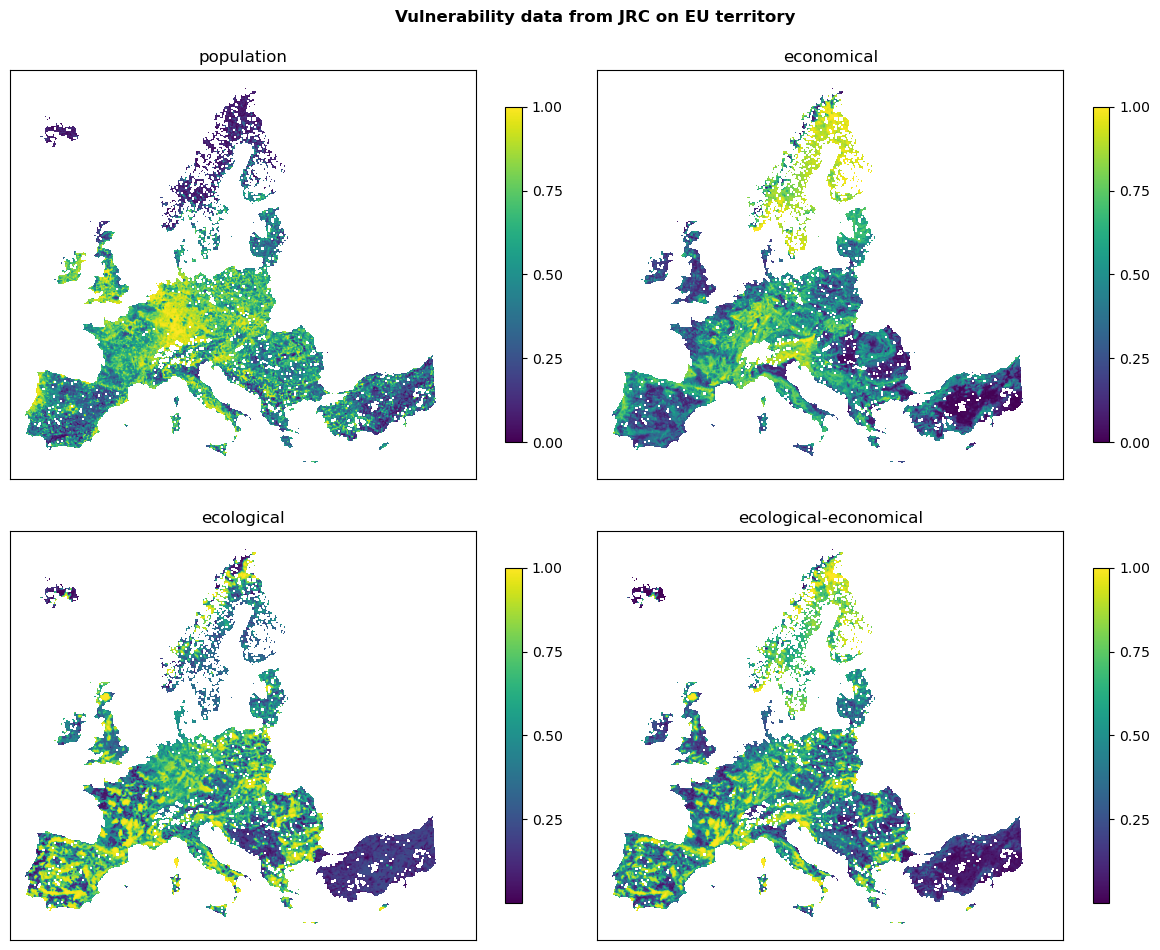

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Vulnerability data from JRC on EU territory', fontweight='bold')

for ax_, (name, path) in zip(ax.flatten(), vul_files_full.items()):
    with rasterio.open(path) as src:
        rasterio.plot.show(src, ax=ax_, cmap='viridis')
        fig.colorbar(ax=ax_, shrink=0.7, ticks=[0, .25, .5, .75, 1], mappable=ax_.images[0])
        ax_.set_title(name, fontsize=12)
        ax_.set_xticks([])
        ax_.set_yticks([])

plt.tight_layout()

#### Clip and resample

In the following, we are clipping the Vulnerability Data to the area of interest (Catalonia) based on the DEM raster and save it in a folder. We are going to use DEM as referenece to clip and align the data (rasters) with its CRS, resolution, and extent.

In [6]:
# Resample data with bilinear method to have a better visualization
resampleAlg = 'bilinear' # other options: 'near', 'bilinear'

# Collect names of clipped vulnerability data files
vul_files_clip = {}

for name, path in vul_files_full.items():
    # Clip the data to the extent of the hazard data
    src = gdal.Open(path)
    clip = gdal.Open(dem_path_clip)
    clip_gt = clip.GetGeoTransform()
    clip_extent = (clip_gt[0], clip_gt[3] + clip_gt[5] * clip.RasterYSize,
            clip_gt[0] + clip_gt[1] * clip.RasterXSize, clip_gt[3])
    # Resmaple and save the data
    out_gt = src.GetGeoTransform()
    out_prj = src.GetProjection()
    vul_files_clip[name] = vul_path / path.name
    dst = gdal.Warp(vul_files_clip[name], src, format='GTiff',
                outputBounds=clip_extent, xRes=100, yRes=100,
                dstSRS=out_prj, dstNodata=-9999, resampleAlg=resampleAlg,
                creationOptions=["COMPRESS=LZW", "PREDICTOR=2", "ZLEVEL=3", "BLOCKXSIZE=512", "BLOCKYSIZE=512"])
    print(vul_files_clip[name])

data_Catalonia/vulnerability/var-vuln-pop_unit-dimensionless.tiff
data_Catalonia/vulnerability/var-vuln-econ_unit-dimensionless.tiff
data_Catalonia/vulnerability/var-vuln-ecol_unit-dimensionless.tiff
data_Catalonia/vulnerability/var-vuln-ecol-econ_unit-dimensionless.tiff


Skip the combined ecological-economical vulnerability for now

In [7]:
del vul_files_clip["ecological-economical"]

#### Visualizing the clipped data 

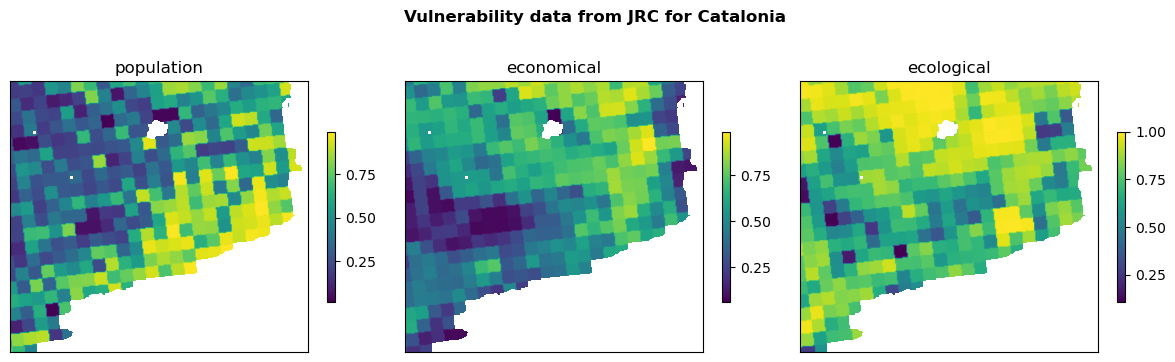

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle(f'Vulnerability data from JRC for {areaname}', fontweight='bold')

for ax_, (name, path) in zip(ax.flatten(), vul_files_clip.items()):
    with rasterio.open(path) as src:
        rasterio.plot.show(src, ax=ax_, cmap='viridis')
        fig.colorbar(ax=ax_, shrink=0.5, ticks=[0, .25, .5, .75, 1], mappable=ax_.images[0])
        ax_.set_title(name)
        ax_.set_xticks([])
        ax_.set_yticks([])

plt.tight_layout()

### Categorized Vulnerability

Categorize vulnerability into 3 classes (low, medium, high) based on either

1. **quantiles** or
2. **thresholds**.

In [9]:
def categorize_with_quantiles(vul_arr):
    """Categorizing based on quantiles: 0 nodata, 1 low, 2 medium, 3 high"""
    # Calculate quantiles
    q1, q2, q3 = np.nanquantile(vul_arr, [.25, 0.5, 0.75])
    # Categorize vulnerability values using fancy indexing
    vul_arr_cat = np.full_like(vul_arr, fill_value=np.nan)
    vul_arr_cat[vul_arr < q1] = 1
    vul_arr_cat[(vul_arr >= q1) & (vul_arr <= q3)] = 2
    vul_arr_cat[vul_arr > q3] = 3
    return vul_arr_cat

def categorize_with_thresholds(vul_arr):
    """Categorizing based on thresholds >>> 0_30, 31_60, 61_100"""
    # Categorize vulnerability values using fancy indexing
    vul_arr_cat = np.full_like(vul_arr, fill_value=np.nan)
    vul_arr_cat[vul_arr < 0.30] = 1
    vul_arr_cat[(vul_arr >= 0.30) & (vul_arr <= 60)] = 2
    vul_arr_cat[vul_arr > 0.60] = 3
    return vul_arr_cat

Choose the method:

In [10]:
categorize = categorize_with_thresholds

Apply the categorization and visualize

dict_keys(['population', 'economical', 'ecological'])
[ 1.  2.  3. nan]


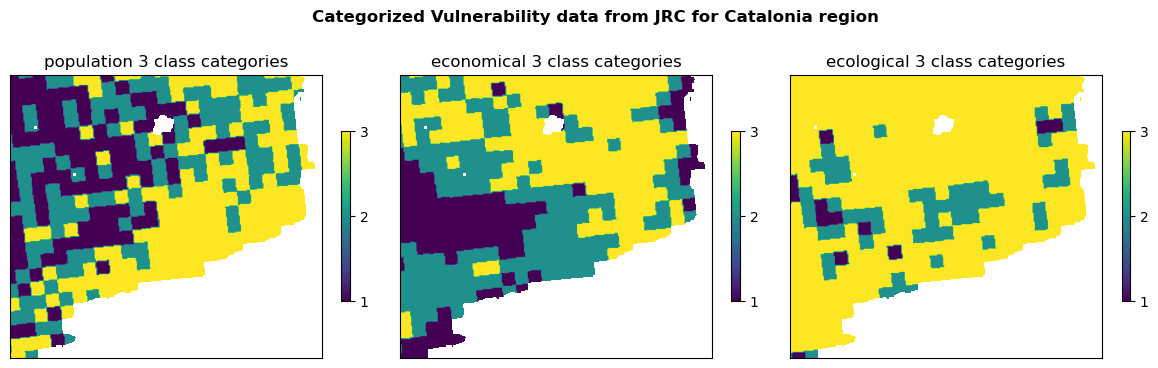

In [11]:
dict_arr_vul_cat = {} # categorized vulnerability data arrays

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle(f'Categorized Vulnerability data from JRC for {areaname} region', fontweight='bold')

for ax_, (name, path) in zip(ax.flatten(), vul_files_clip.items()):
    # Load and process the vulnerability data
    with rasterio.open(path) as f:
        vul_arr = f.read(1)
        vul_arr = np.where(vul_arr > 0, vul_arr, np.nan)
        vul_arr = categorize(vul_arr)
    # Visualize the categorized vulnerability data
    img = ax_.imshow(vul_arr, cmap="viridis")
    fig.colorbar(img, ax=ax_, shrink=.5, ticks=[1, 2, 3])
    ax_.set_title(f'{name} 3 class categories')
    ax_.set_xticks([])
    ax_.set_yticks([])
    # Collect categorized arrays for later use
    dict_arr_vul_cat[name] = vul_arr

plt.tight_layout()

print(dict_arr_vul_cat.keys())
print(np.unique(vul_arr))

### Exposure

#### Load elements at risk data

In [12]:
exp_data_vector = { element: gpd.read_file(path) for element, path in exp_files.items() }

# Area of interest for geographical context
region_borders = gpd.read_file(bounds_path_area)

#### Visualize vector layers

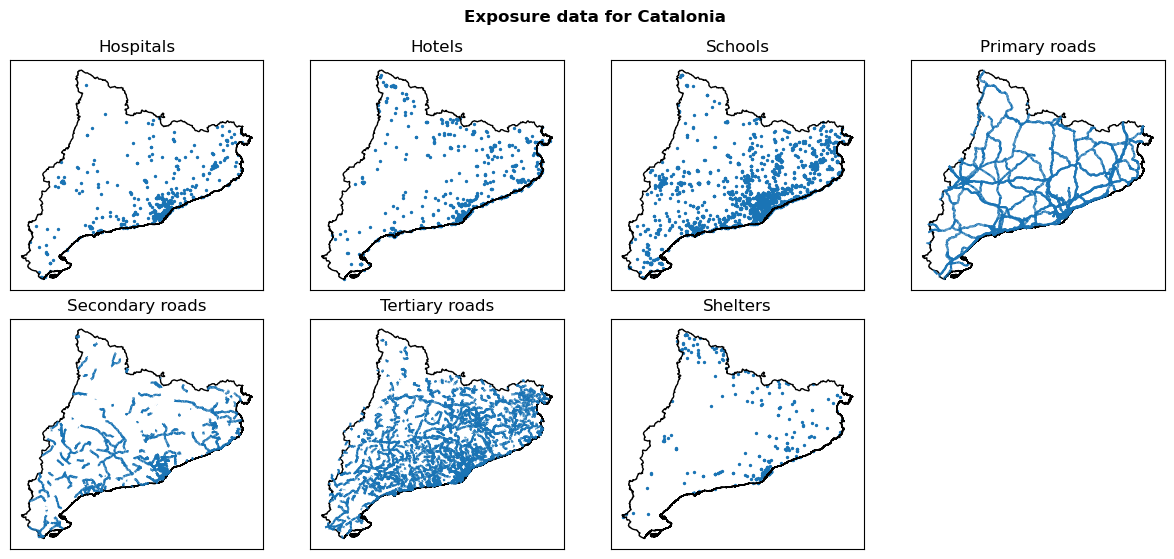

In [13]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle(f"Exposure data for {areaname}", fontweight="bold")

for ax_, (name, exp_vector) in zip(ax.flatten(), exp_data_vector.items()):
    exp_vector.plot(ax=ax_, color="#1A74B5", label=name, markersize=2)
    region_borders.plot(ax=ax_, facecolor='none', edgecolor='black')
    ax_.set_title(name)
    ax_.set_xticks([])
    ax_.set_yticks([])

plt.tight_layout()
ax[1,3].remove()

#### Rasterize vector layers

In [14]:
exp_data_raster = {
    name: rasterize_numerical_feature(exp_vector, dem_path_clip)
    for name, exp_vector in exp_data_vector.items()
}

Shape of the reference raster: (2554, 2810)
Transform of the reference raster: | 100.00, 0.00, 3488731.36|
| 0.00,-100.00, 2241986.65|
| 0.00, 0.00, 1.00|
Features.rasterize is launched...
Features.rasterize is done...
Shape of the reference raster: (2554, 2810)
Transform of the reference raster: | 100.00, 0.00, 3488731.36|
| 0.00,-100.00, 2241986.65|
| 0.00, 0.00, 1.00|
Features.rasterize is launched...
Features.rasterize is done...
Shape of the reference raster: (2554, 2810)
Transform of the reference raster: | 100.00, 0.00, 3488731.36|
| 0.00,-100.00, 2241986.65|
| 0.00, 0.00, 1.00|
Features.rasterize is launched...
Features.rasterize is done...
Shape of the reference raster: (2554, 2810)
Transform of the reference raster: | 100.00, 0.00, 3488731.36|
| 0.00,-100.00, 2241986.65|
| 0.00, 0.00, 1.00|
Features.rasterize is launched...
Features.rasterize is done...
Shape of the reference raster: (2554, 2810)
Transform of the reference raster: | 100.00, 0.00, 3488731.36|
| 0.00,-100.00, 2

#### Visualize raster layers

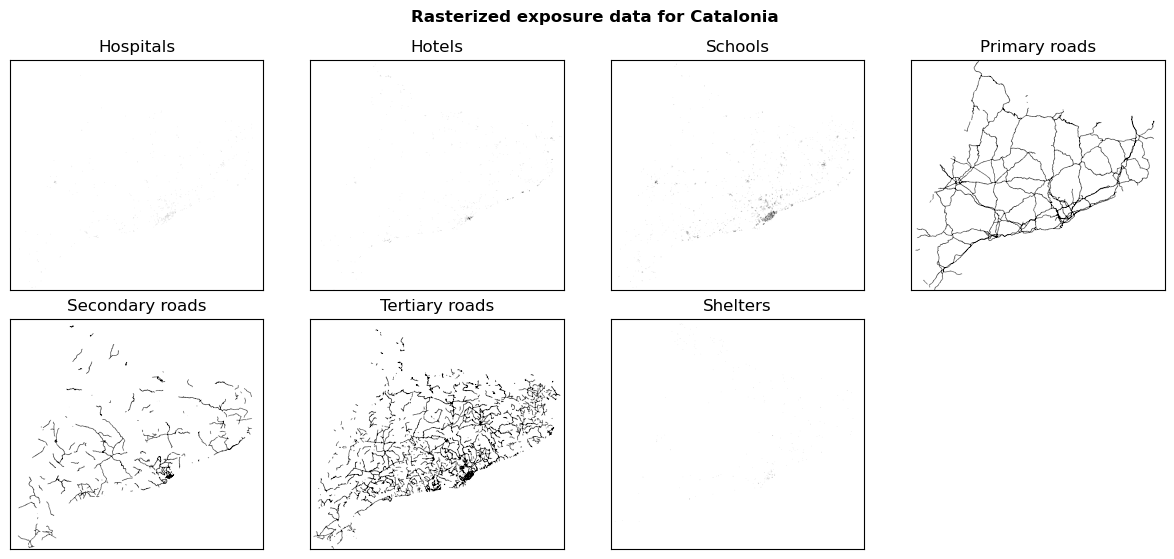

In [15]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle(f"Rasterized exposure data for {areaname}", fontweight="bold")

for ax_, (name, exp_arr) in zip(ax.flatten(), exp_data_raster.items()):
    ax_.imshow(exp_arr, cmap="binary", vmax=0.2)
    ax_.set_title(name)
    ax_.set_xticks([])
    ax_.set_yticks([])
    ax_.title.set_text(name)

plt.tight_layout()
ax[1,3].remove()

#### Saving rasterized exposure data

Run the following cell if saving the exposure data (rasters) is needed.

In [16]:
for name, exp_arr in exp_data_raster.items():
    _name = name.replace(" ", "_").lower()
    save_raster_as(exp_arr, exp_path / f"{_name}_rasterized.tif", dem_path_clip, dtype='int32', count=1)

## Methodologies to calculate risk

1. Risk = Hazard × Vulnerabilty (categorized)
2. Risk = Hazard × Exposure (categorized roads) with assigning a matrix of damage

Risk matrix:

In [17]:
#                          ---- Hazard ----
#                          1  2  3  4  5  6
#                          ----------------
risk_matrix = np.array([[1, 1, 1, 2, 3, 4],  # 1 | Damage/
                        [1, 1, 2, 3, 4, 4],  # 2 |   vulnerability
                        [1, 2, 3, 4, 4, 4]]) # 3 |   level

Contingency table that is going to be used to define Risk Maps:

![image.png](images/contingency_table.png), ![image-2.png](images/risk_scale.png)

## Load hazard data

Import raster layers from the Hazard assessment workflow.

Choose a [historical period](Hazard_assessment_FIRE_ML.ipynb#select-historical-period-for-model-training) as in the Hazard assessment:

In [18]:
hist_period = "199110"

In [19]:
hist_config_id = f"HIST_{hist_period}"
hist_period_print = hist_period[:-2] + "-" + hist_period[-2:]

hazard_path_hist = hazard_path / f"hazard_{hist_config_id}.tif"
assert hazard_path_hist.is_file(), "Historical hazard data not found, please run the Hazard workflow first"

with rasterio.open(hazard_path_hist) as src:
    hazard_arr_hist = src.read(1)

Choose a [future scenario, period and climate model](Hazard_assessment_FIRE_ML.ipynb#future-scenario-and-period-and-climate-model-selection) as in the Hazard assessment.

:::{tip}
You can return to this point of the workflow and rerun the following cells for different combinations of RCP scenario, time period and climate model to explore the risk in different futures.
:::

In [20]:
future_scenario = "RCP45"
future_period = "202140"
climate_model = "CLMcom_CCLM"

In [21]:
future_config_id = f"{future_scenario}_{climate_model}_{future_period}"
future_period_print = future_period[:-2] + "-" + future_period[-2:]

hazard_path_future = hazard_path / f"hazard_{future_config_id}.tif"
assert hazard_path_future.is_file(), "Future hazard data not found, please run the Hazard workflow first"

with rasterio.open(hazard_path_future) as src:
    hazard_arr_future = src.read(1)

## Risk method 1: Hazard × Vulnerabilty (categorized)

Risk under consideration of population vulnerability and hazard.

### Calculate risk

In [22]:
risk1_hist = {
    name: contigency_matrix_on_array(vul_arr, hazard_arr_hist, risk_matrix, np.nan, 0)
    for name, vul_arr in dict_arr_vul_cat.items()
}

risk1_future = {
    name: contigency_matrix_on_array(vul_arr, hazard_arr_future, risk_matrix, np.nan, 0)
    for name, vul_arr in dict_arr_vul_cat.items()
}

### Visualization of risk maps

Reference raster for plotting:

In [23]:
with rasterio.open(dem_path_clip) as src:
    ref = src.read(1)

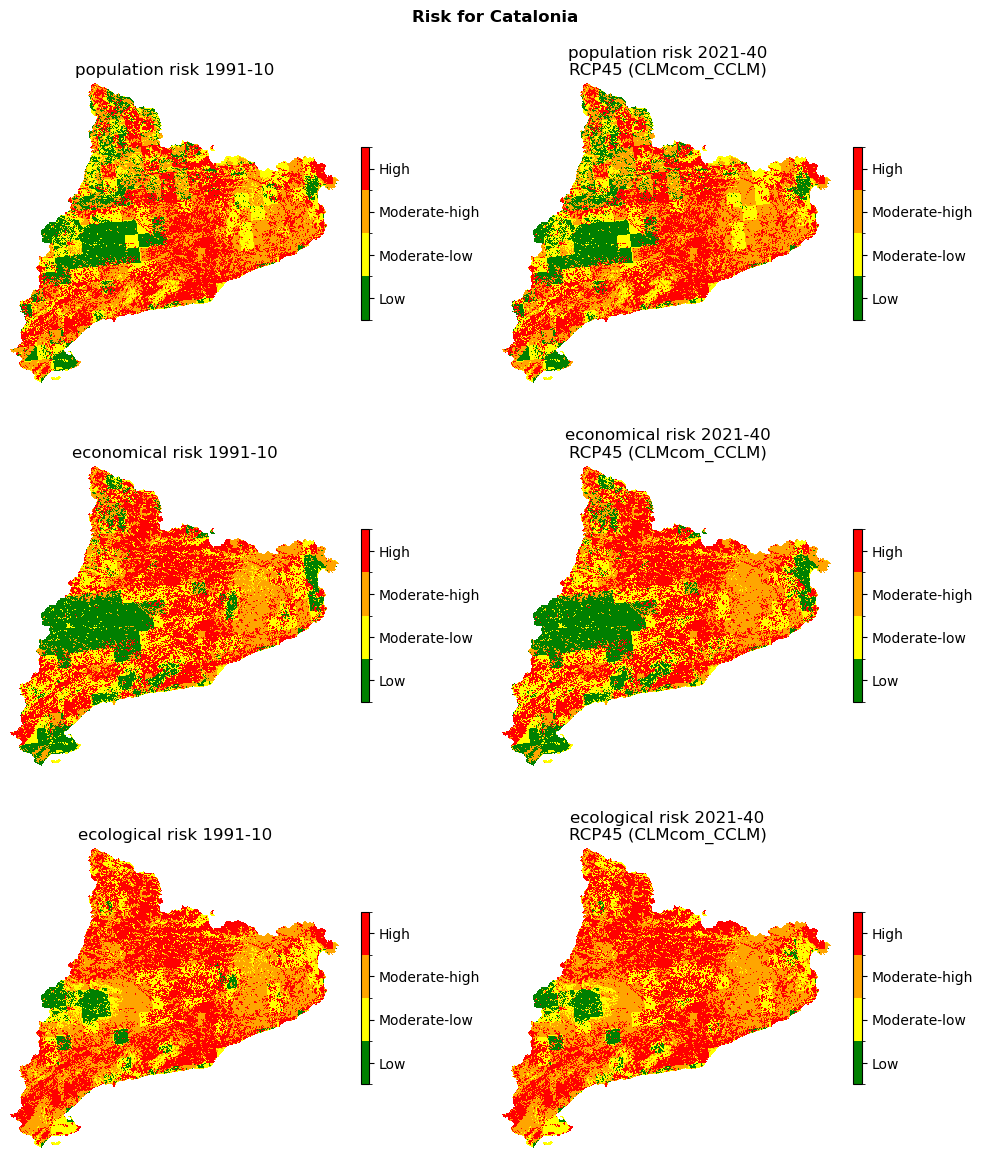

In [24]:
fig, ax = plt.subplots(3, 2, figsize=(10, 12))
fig.suptitle(f"Risk for {areaname}", fontweight="bold")

classes_colors = ['green', 'yellow', 'orange', 'red']
classes_names = ['Low', 'Moderate-low', 'Moderate-high', 'High']
risk_plot_kwargs = {
    "shrink_legend": 0.5,
    "array_classes": [0, 1.1, 2.1, 3.1, 4.1],
    "classes_colors": classes_colors,
    "classes_names": classes_names
}

for ax_, (name, risk_arr) in zip(ax[:,0], risk1_hist.items()):
    title = f"{name} risk {hist_period_print}"
    plot_raster_V2(risk_arr, ref, add_to_ax=(fig, ax_), title=title, **risk_plot_kwargs)

for ax_, (name, risk_arr) in zip(ax[:,1], risk1_future.items()):
    title = f"{name} risk {future_period_print}\n{future_scenario} ({climate_model})"
    plot_raster_V2(risk_arr, ref, add_to_ax=(fig, ax_), title=title, **risk_plot_kwargs)

fig.tight_layout()
fig.savefig(maps_path / f"risk1_{hist_config_id}_{future_config_id}.png", dpi=150)

Save the risk maps as rasters:

In [25]:
# Historical risk
for name, risk_arr in risk1_hist.items():
    filename = risk_path / f"risk1_{name}_{hist_config_id}.tif"
    save_raster_as(np.where(ref == -9999, np.NaN, risk_arr), filename, dem_path_clip, novalue=np.nan)

# Future risk
for name, risk_arr in risk1_future.items():
    filename = risk_path / f"risk1_{name}_{future_config_id}.tif"
    save_raster_as(np.where(ref == -9999, np.NaN, risk_arr), filename, dem_path_clip, novalue=np.nan)

### Risk at municipality level using NUTS

Get the NUTS level of the area of interest from the shapefile:

<Axes: >

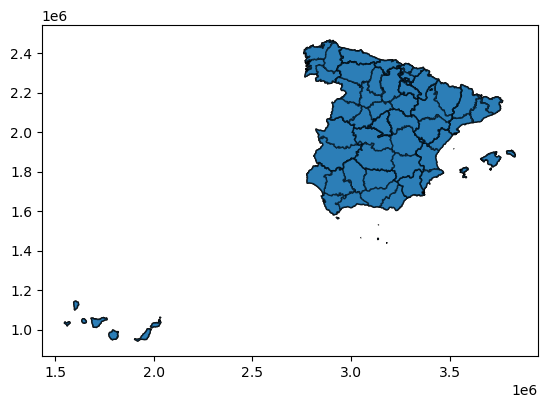

In [26]:
# Alpha-2 code of the country of area of interest
CNTR_CODE= 'ES'

# Read the shapefile
nuts_eu = gpd.read_file(nuts_path)

# Plot the NUTS level of the area of interest
nuts_eu[nuts_eu['CNTR_CODE'] == CNTR_CODE].plot(alpha=0.5, edgecolor='black')

Extract for the region of interest

In [27]:
# Example: Catalonia
NUTS_ID = ['ES511', 'ES512', 'ES513', 'ES514']

region_nuts3 = nuts_eu[nuts_eu['NUTS_ID'].isin(NUTS_ID)]

### Aggregate at NUTS3 level

Function to calculate zonal statistics:

In [28]:
def zonal_statistics(gdf, raster_arr, ref_path, name_col, mode='mean', weights: dict = None):
    # Get transform information from reference raster file
    with rasterio.open(ref_path) as raster:
        transform = raster.profile["transform"]
    # Iterate over sub-domains
    for idx in list(gdf.index):
        geom = gpd.GeoSeries(gdf.loc[idx].geometry, name='geometry')
        mask = rasterio.features.geometry_mask(
            geom, out_shape=raster_arr.shape, transform=transform, invert=True
        )
        # Apply the mask to obtain values from current domain only
        adm = raster_arr[mask]
        # Aggregate with specified function
        if mode == 'mean':
            result = np.nanmean(adm)
        elif mode == 'most_frequent':
            try:
                result = np.argmax(np.bincount(adm[~np.isnan(adm)].astype(int)))
            except ValueError: # empty sequence
                result = np.NaN
        elif mode == 'sum':
            result = np.nansum(adm)
        elif mode == 'max':
            result = np.nanmax(adm)
        elif mode == 'min':
            result = np.nanmin(adm)
        elif mode == 'q1':
            result = np.nanquantile(adm, 0.25)
        elif mode == 'q3':
            result = np.nanquantile(adm, 0.75)
        elif mode == 'weighted_mean':
            classes = weights.keys()
            weight = list(weights.values())
            # Count all the pixels excluding the one not in interested classes (no data)
            num_pixels = np.nansum(np.where(np.isin(adm, list(classes)), 1, 0))
            percentage_classes = []
            for _class in classes:
                percentage_class = (np.where(adm == _class, 1, 0).sum() / num_pixels) * 100
                percentage_classes.append(percentage_class)
            terms = [perc_class * weight for perc_class, weight in zip(percentage_classes, weight)]
            result = sum(terms)
            print(f'percentage sum: {percentage_classes}, weight sum: {weight}, result: {result}')
        else:
            raise ValueError(f'mode {mode} not recognized')

        gdf.loc[idx, name_col] = result

    return gdf

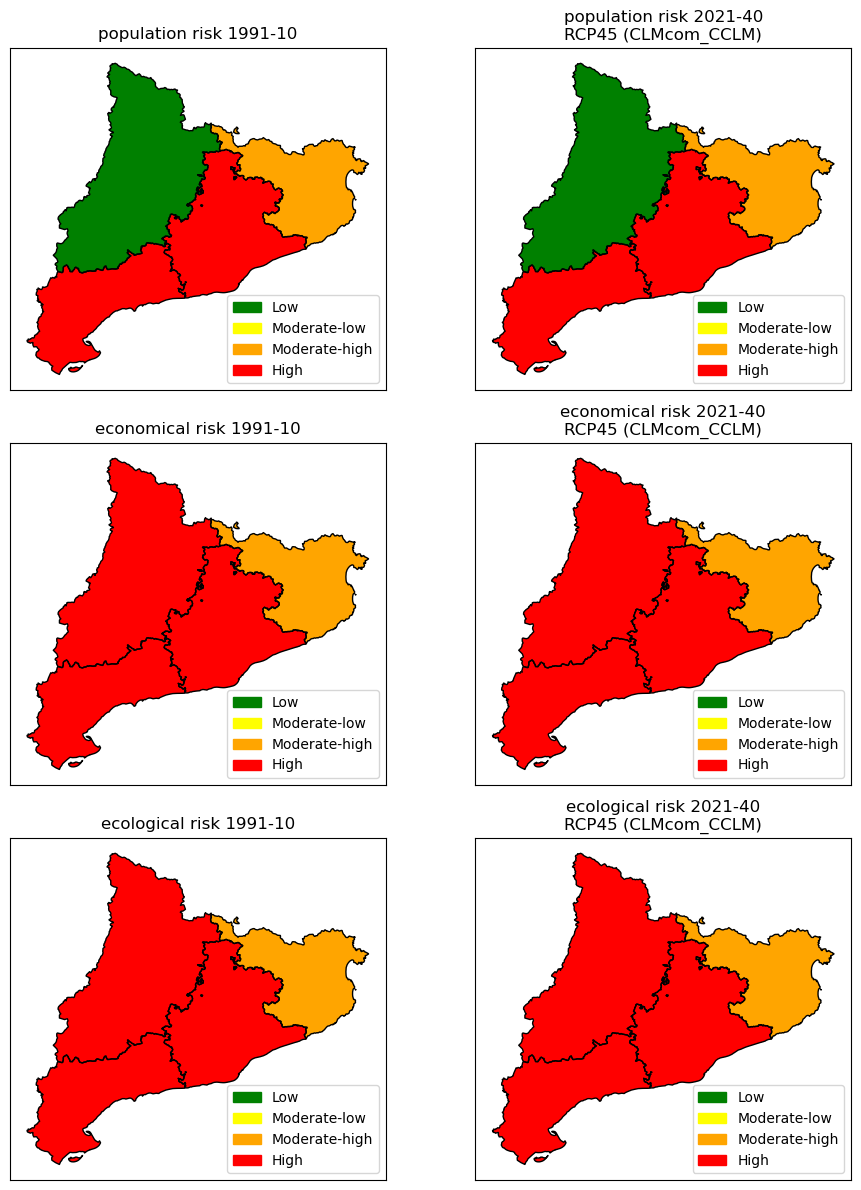

In [29]:
fig, ax = plt.subplots(3, 2, figsize=(10, 12))

risk_plot_kwargs = {
    "vmin": 0.1,
    "vmax": 4.1,
    "cmap": colors.ListedColormap(classes_colors)
}

# Historical
for ax_, (name, risk_arr) in zip(ax[:,0], risk1_hist.items()):
    ax_.set_title(f"{name} risk {hist_period_print}")
    gdf = zonal_statistics(region_nuts3, risk_arr, dem_path_clip, name_col='Risk', mode='most_frequent')
    gdf.plot(ax=ax_, column='Risk', **risk_plot_kwargs)
    region_nuts3.plot(ax=ax_, facecolor="none", edgecolor="black")

# Future
for ax_, (name, risk_arr) in zip(ax[:,1], risk1_future.items()):
    ax_.set_title(f"{name} risk {future_period_print}\n{future_scenario} ({climate_model})")
    gdf = zonal_statistics(region_nuts3, risk_arr, dem_path_clip, name_col='Risk', mode='most_frequent')
    gdf.plot(ax=ax_, column='Risk', **risk_plot_kwargs)
    region_nuts3.plot(ax=ax_, facecolor="none", edgecolor="black")

for ax_ in ax.flatten():
    ax_.set_xticks([])
    ax_.set_yticks([])
    ax_.legend(
        handles=[Patch(color=color) for color in classes_colors],
        labels=classes_names,
        loc="lower right"
    )

fig.tight_layout()
fig.savefig(maps_path / f"risk1_NUTS3_{hist_config_id}_{future_config_id}.png", dpi=150)

## Risk Method 2: Hazard × Exposure (roads)

### Creating a classed raster of roads

Each road class has a level of vulnerability:

- **Primary**: low, 1
- **Secondary**: moderate, 2
- **Tertiary**: high, 3

In [30]:
# Buffer the roads
buffered_primary_roads = buffer(exp_data_raster['Primary roads'], pixel_radius=2)
buffered_secondary_roads = buffer(exp_data_raster['Secondary roads'], pixel_radius=2)
buffered_tertiary_roads = buffer(exp_data_raster['Tertiary roads'], pixel_radius=2)

roads_vul_arr = np.zeros_like(buffered_primary_roads, dtype=np.float32)
roads_vul_arr[buffered_primary_roads == 1] = 1
roads_vul_arr[buffered_secondary_roads == 1] = 2
roads_vul_arr[buffered_tertiary_roads == 1] = 3
roads_vul_arr[ref == -9999] = np.NaN

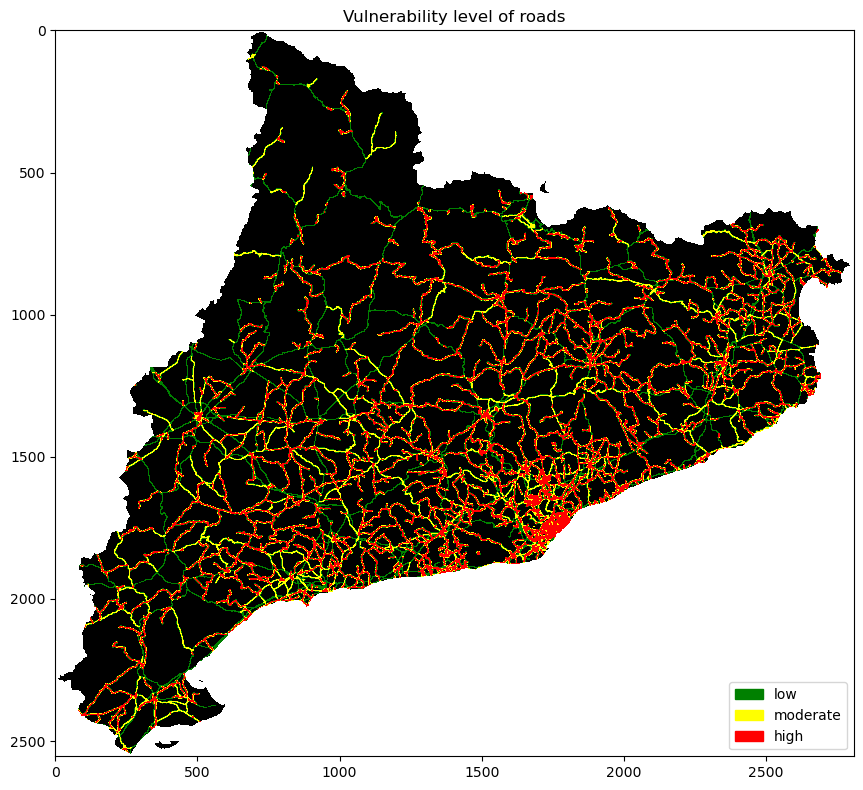

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.set_title("Vulnerability level of roads")

cmap = ListedColormap(["black", 'green', 'yellow', 'red'])
ax.imshow(roads_vul_arr, cmap=cmap, vmin=0, vmax=3)
ax.legend(
    handles=[Patch(color=cmap(i)) for i in [1, 2, 3]],
    labels=["low", "moderate", "high"],
    loc="lower right"
)

fig.tight_layout()

### Calculate risk in roads

In [32]:
risk2_roads_hist = contigency_matrix_on_array(roads_vul_arr, hazard_arr_hist, risk_matrix, 0, 0)
risk2_roads_future = contigency_matrix_on_array(roads_vul_arr, hazard_arr_future, risk_matrix, 0, 0)

### Visualization of risk maps

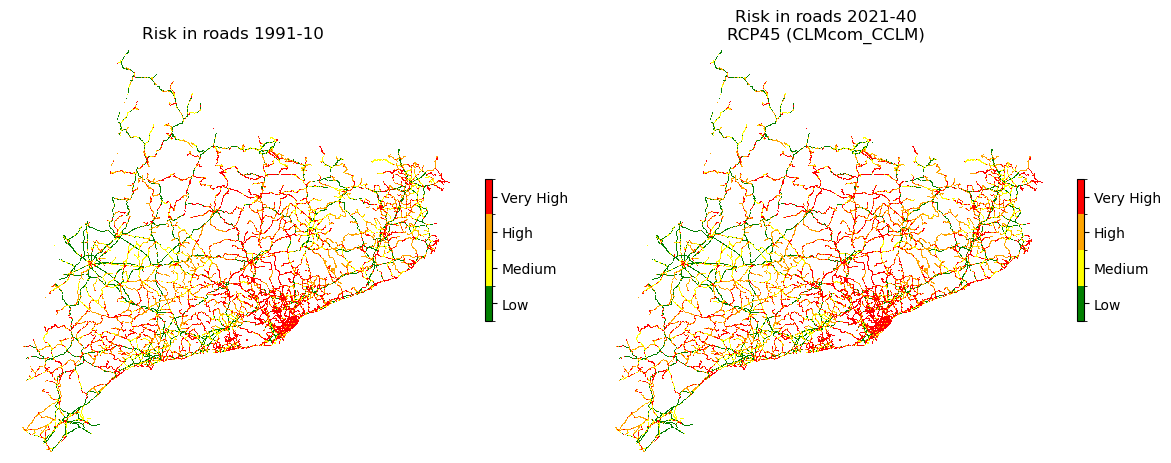

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

risk_plot_kwargs = {
    "shrink_legend": 0.25,
    "array_classes": [0, 1.1, 2.1, 3.1, 4.1],
    "classes_colors": ['green', 'yellow', 'orange', 'red'],
    "classes_names": ['Low', 'Medium', 'High', 'Very High']
}

ref_r = np.where(roads_vul_arr == 0, -9999, ref)

plot_raster_V2(risk2_roads_hist, ref_r, add_to_ax=(fig, ax[0]), **risk_plot_kwargs,
        title=f"Risk in roads {hist_period_print}")

plot_raster_V2(risk2_roads_future, ref_r, add_to_ax=(fig, ax[1]), **risk_plot_kwargs,
        title=f"Risk in roads {future_period_print}\n{future_scenario} ({climate_model})")

fig.tight_layout()
fig.savefig(maps_path / f"risk2_roads_{hist_config_id}_{future_config_id}.png", dpi=150)

Save the risk maps as rasters:

In [34]:
# Historical risk
filename = risk_path / f"risk2_roads_{hist_config_id}.tif"
save_raster_as(np.where(ref_r == -9999, np.NaN, risk2_roads_hist), filename, dem_path_clip, novalue=np.nan)

# Future risk
filename = risk_path / f"risk2_roads_{future_config_id}.tif"
save_raster_as(np.where(ref_r == -9999, np.NaN, risk2_roads_future), filename, dem_path_clip, novalue=np.nan)

## Conclusion

In this Notebook, for a given area where hazard (for several projected times), exposures and vulnerability were already present,risk has been evaluated following simple rules, and adopting different strategies. The proposed framework can be applied to any study area given that hazard (by the means of the previous Notebook) is available.  

## Contributors

- Andrea Trucchia (Andrea.trucchia@cimafoundation.org)
- Farzad Ghasemiazma (Farzad.ghasemiazma@cimafoundation.org)
- Giorgio Meschi (Giorgio.meschi@cimafoundation.org)